# New functionalities in version 0.4.0

This version include new functionalities about extended precision (work with words larger than 64 bits) and support numpy functions, among others. This notebook has some examples of these functionalities. For more information see [documentation web site](https://francof2a.github.io/fxpmath/).

**Changelog**:

* Extended precision (beyond 64 bits) in `add`, `sub`, `mult`, `truediv`, `floordiv`, `mod` and `pow` functions and methods (operators).
* Support new input formats for values: `tuples`, `Decimal` type from `decimal` module.
* dtype can be specified at init if `fxp` format or `Q` format (it replaces explicit sizing by signed, n_word, and n_frac parameters).
* Template functionality added. It allows define default format for new Fxp objects.
* Config class created to manage low level configuration of Fxp object's behavior.
    - size limits: `max_error`, `n_word_max`. Parameters to define n_word and n_frac of a new Fxp.
    - behavior: `op_method` (defines calculation method for ALU operators).
    - inputs: `op_input_size` (defines sizing of constant conversion to Fxp in math operations).
    - alu ops outpus: `op_out`, `op_out_like`, `op_sizing` (define the sizing method or type for results of ALU operations).
    - alu ops with a constant operand: `const_op_sizing` (alternative of `op_sizing` when one of ALU operands is a constant).
    - array ops: `array_output_type` (defines the object type when use Numpy functions: Numpy Array or Fxp),
    `array_op_out`, `array_op_out_like` (define the output's size), `array_op_method` (defines calculation method for ALU operators).
* Several core calculations/methods mirgrated from `float` to `int` to support extended precision.
* Extended precision flag in status (extended_prec).
* Results of ALU operations with constants keep same size than Fxp object (by default).
* `like` initialization supports overwrite of size parameters.
* Numpy functions dispatch. You can use Fxp as arguments (inputs) of Numpy functions and get Fxp as outputs of them.
* New Fxp properties: size, shape, ndim, T.
* New Fxp methods: reshape, flatten, raw, uraw.
* New Fxp methods from Numpy array methods: all, any, argmax, argmin, argpartition, argsort, max, min, mean, std, var, sum, cumsum, cumprod, 
  ravel, tolist, sort, conjugate, conj, transpose, item, clip, diagonal, trace, prod, dot, nonzero.
* Support for `bool`, `int`, `float` and `complex` casting.
* dtype included in Fxp's representation (__repr__).
* Callbacks (basic) functionality added: `on_value_change`, `on_status_overflow`, `on_status_underflow`, `on_status_inaccuracy`.
* Some performance improvements.


In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from fxpmath import Fxp
import fxpmath as fxp

## Extended precision

Numpy works up to 64 bits for its `int` types: `int64` and `uint64`. *fxpmath* works internally with some of these types depending of `Fxp` is signed or not. When a fixed point variable has to be larger than 64 bits, it's necessary to work with **extended precision** (Fxp works with python `int` type instead of numpy types, but supporting numpy `ndarray`).

Let's create a Fxp with 256 bits for word and 248 bits for fractional part:

In [2]:
xe = Fxp([-1.2, 0., 1.5], signed=True, n_word=256, n_frac=248)

xe.info(3)

	dtype		=	fxp-s256/248
	Value		=	[-1.2 0.0 1.5]
	extended_prec	=	True

	Signed		=	True
	Word bits	=	256
	Fract bits	=	248
	Int bits	=	7
	Val data type	=	float64

	Upper		=	128.0
	Lower		=	-128.0
	Precision	=	2.210859150104178e-75
	Overflow	=	saturate
	Rounding	=	trunc
	Shifting	=	expand



Note that flag `extended_prec` is `True`.

Working with extended precision allows better precision than `float64`. Following example shows losing information because limited precision of float:

In [3]:
a = np.array(1.)
b = np.array(2**(-96))
print('a = {}'.format(a))
print('b = {}'.format(b))

c = (a + b) - a
print('c = {} (c should be equal to b)'.format(c))

a = 1.0
b = 1.262177448353619e-29
c = 0.0 (c should be equal to b)


In [4]:
a_e = Fxp(1., True, 128, 96)
b_e = Fxp(2**(-96), True, 128, 96)
print('a_e = {}'.format(a_e))
print('b_e = {}'.format(b_e))

c_e = (a_e + b_e) - a_e
print('c_e = {} (c_e should be equal to b_e)'.format(c_e))

a_e = 1.0
b_e = 1.262177448353619e-29
c_e = 1.262177448353619e-29 (c_e should be equal to b_e)


It's because $a_e + b_e$ can handle with a high dynamic range. Another way to see that is inspecting binary representation:

In [5]:
print('a_e =         {}'.format(a_e.bin(frac_dot=True)))
print('b_e =         {}'.format(b_e.bin(frac_dot=True)))
print('\na_e + b_e =  {}'.format((a_e+b_e).bin(frac_dot=True)))

a_e =         00000000000000000000000000000001.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
b_e =         00000000000000000000000000000000.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001

a_e + b_e =  000000000000000000000000000000001.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001


The common arithmetic functions support *extended precision* in order to return the result with rigth size and value:

In [6]:
x = Fxp(1.0, True, 128, 96)
y = Fxp(3.0, True, 128, 96)

z = x / y

z.info()
print('Init with Fxp result:')
print(z.bin(frac_dot=True))

z_float = Fxp(1.0/3.0, True, 256, 127)
print('Init with float:')
print(z_float.bin(frac_dot=True))

	dtype		=	fxp-s256/127
	Value		=	0.3333333333333333
	inaccuracy	=	True
	extended_prec	=	True

Init with Fxp result:
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000.0101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010
Init with float:
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000.0101010101010101010101010101010101010101010101010101010000000000000000000000000000000000000000000000000000000000000000000000000


Note that less significant bits of Fxp are not all zeros just like a float version.

## Decimal input

In [7]:
from decimal import Decimal, getcontext

In [8]:
d = Fxp(Decimal(0.25), True, 16, 8)
print(d)

0.25


This format could be useful for extended precision:

In [9]:
fxp_precision = 128
decimal_precision = int(np.ceil(np.log10(2.**fxp_precision)))
getcontext().prec = decimal_precision

d_val = Decimal(1) / Decimal(3)
print('decimal = {}'.format(d_val))

d = Fxp(d_val, True, fxp_precision+16, fxp_precision)
print('fxp = {}'.format(d))
print(d.bin(True))

decimal = 0.333333333333333333333333333333333333333
fxp = 0.3333333333333333
0000000000000000.01010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101


## input dtype format 
Fxp can be initialized using a string for *dtype*, instead of parameters `signed`, `n_word`, `n_int` or `n_frac`.

One way is using **fxp format**: **`fxp-<sign><n_word>/<n_frac>-{complex}`** i.e.: `fxp-s16/15`, `fxp-u8/1`, `fxp-s32/24-complex`.

Another way is using **Q format**: `Qm.n` or `UQm.n` notation (or the equivalent `Sm.n`/`Um.n` notation).

*Thanks to @NJDFan*

In [10]:
x = Fxp(-7.25, dtype='fxp-s16/8')
x.info()

x = Fxp(-7.25, dtype='S8.8')
x.info()

	dtype		=	fxp-s16/8
	Value		=	-7.25

	dtype		=	fxp-s16/8
	Value		=	-7.25



## Template

A **Fxp Template** is available to define the default size of Fxp new objects:

In [11]:
# Template is defined inside Fxp class
Fxp.template = Fxp(None, dtype='fxp-s24/8')

x = Fxp(0.25)
y = Fxp(-12.75)

x.info()
y.info()

	dtype		=	fxp-s24/8
	Value		=	0.25

	dtype		=	fxp-s24/8
	Value		=	-12.75



In this way, is not necessary to specify the size parameters each time.

A template can be change on the fly, affecting only the new Fxp object created after that change:

In [12]:
Fxp.template = Fxp(None, dtype='fxp-s16/4')

x = Fxp(0.25)
y = Fxp(-12.75)

Fxp.template = Fxp(None, dtype='fxp-s32/8')

z = Fxp(0.1)

x.info()
z.info()

	dtype		=	fxp-s16/4
	Value		=	0.25

	dtype		=	fxp-s32/8
	Value		=	0.09765625
	inaccuracy	=	True



In [13]:
Fxp.template = None # disable template

## `like` init supports overloading

Now it is possible to modify some size parameter when new Fxp is initialized using `like`:

In [14]:
x = Fxp(20.5, dtype='fxp-s24/16') # reference

y = Fxp(-3.625, like=x) # common like init
z = Fxp(-3.625, like=x, n_word=32) # like x but with 32 bits for word

y.info()
z.info()

	dtype		=	fxp-s24/16
	Value		=	-3.625

	dtype		=	fxp-s32/16
	Value		=	-3.625



# Numpy dispatch

One of the biggest improvement of *fxpmath* in this version is supporting for **numpy's functions**.

- Numpy functions supports Fxp objects like inputs, returning Fxp objects.
- Fxp try to resolve the functions using extendend precision, but if a function is not implemented with this feature, is calculated using Fxp representation value.

In [15]:
N = 100
f = 130
fs = 2e3

n_fxp = Fxp(np.arange(N), dtype='fxp-s24/4') # sample vector in fixed point precision
y = np.sin(2*np.pi*f*n_fxp/fs)  # numpy sin function takes a Fxp as input

print(type(y))  # y is a Fxp object returned by numpy function
print(y.dtype)  # output size is calculated according values and input sizes

<class 'fxpmath.objects.Fxp'>
fxp-s59/58


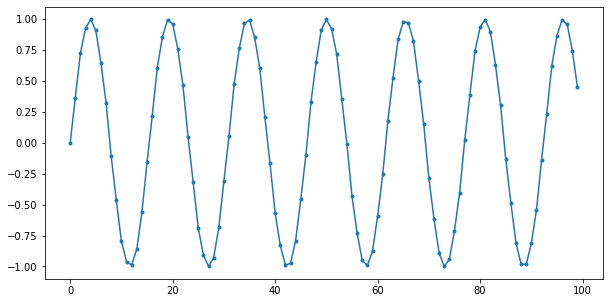

In [16]:
plt.figure(figsize=(10,5))
plt.plot(n_fxp, y, marker='.')
plt.show()

Output format could be specified using `out_like` parameter, doing:

In [17]:
y_24_22 = np.sin(2*np.pi*f*n_fxp/fs, out_like=Fxp(dtype='fxp-s24/22'))
print(y_24_22.dtype)

fxp-s24/22


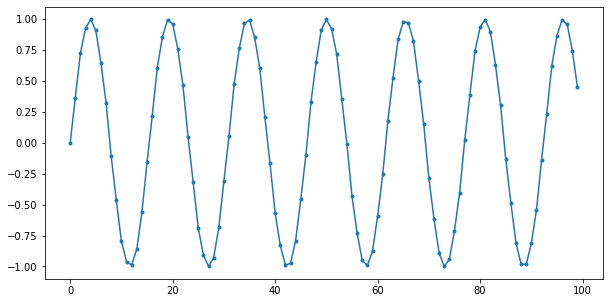

In [18]:
plt.figure(figsize=(10,5))
plt.plot(n_fxp, y_24_22, marker='.')
plt.show()

Result can be also stored ina predefined Fxp variable, using `out` parameter:

In [19]:
z = Fxp(None, dtype='fxp-s16/4')
np.sin(2*np.pi*f*n_fxp/fs, out=z)

fxp-s16/4([ 0.      0.3125  0.6875  0.875   0.9375  0.875   0.625   0.3125 -0.0625
           -0.4375 -0.75   -0.9375 -0.9375 -0.8125 -0.5    -0.125   0.1875  0.5625
            0.8125  0.9375  0.9375  0.75    0.4375  0.     -0.3125 -0.6875 -0.875
           -0.9375 -0.875  -0.625  -0.25    0.      0.4375  0.75    0.9375  0.9375
            0.8125  0.5625  0.1875 -0.125  -0.5625 -0.8125 -0.9375 -0.9375 -0.75
           -0.4375 -0.0625  0.3125  0.625   0.875   0.9375  0.875   0.6875  0.3125
            0.     -0.375  -0.6875 -0.9375 -0.9375 -0.875  -0.5625 -0.25    0.125
            0.5     0.8125  0.9375  0.9375  0.8125  0.5     0.125  -0.25   -0.5625
           -0.875  -0.9375 -0.9375 -0.6875 -0.375   0.      0.375   0.6875  0.875
            0.9375  0.875   0.625   0.25   -0.125  -0.4375 -0.75   -0.9375 -0.9375
           -0.8125 -0.5    -0.125   0.1875  0.625   0.8125  0.9375  0.9375  0.6875
            0.4375])

## Config (behaviors)

The new parameter `config`, a class indeed, is a parameters set which determines the behavior of a Fxp object in several processes.

Let's take a look over this class:

In [20]:
x = Fxp(None, True, 16, 4)
x.config.print()

	max_error               :	1.0842021724855044e-19
	n_word_max              :	64
	overflow                :	saturate
	rounding                :	trunc
	shifting                :	expand
	op_method               :	raw
	op_input_size           :	same
	op_out                  :	None
	op_out_like             :	None
	op_sizing               :	optimal
	const_op_sizing         :	same
	array_output_type       :	fxp
	array_op_out            :	None
	array_op_out_like       :	None
	array_op_method         :	repr
	dtype_notation          :	fxp


The first 5 parameters were present in older versions, but they were move here. Note that size parameters don't live here.

Following sections will explain breafly each new parameter.

### op_method

This parameter defines if a operation involving its Fxp object is going to be performed using `raw` or `repr` method.

The 'raw' method use the `int` internal representation of data, whilst 'repr' use the original type of data for the operation. The `raw` method is more accurate and emulate binary level operation, but is slower most of cases. This method is needed in cases of *extended precision*.

In [21]:
a = Fxp([-1.0, 0.0, 1.0], True, 128, 96)
b = Fxp([2**-64, -2**48, 2**32], True, 128, 96)

c = a + b
print(c)
print(c-a) # equal to b

[-1.0 -2147483648.0 2147483649.0]
[5.421010862427522e-20 -2147483648.0 2147483648.0]


In [22]:
a.config.op_method = 'repr'
b.config.op_method = 'repr'

c = a + b
print(c)
print(c-a) # should be equal to b, but it doesn't

[-1.0 -2147483648.0 2147483649.0]
[0.0 -2147483648.0 2147483648.0]


Using `repr`, addition is equivalent to c = Fxp(a() + b()). The fist value ef $c - a$ is not equal to first value of $b$ because $2^{-64}$ has been lost when it was added to $1.0$ becuase *float precision* limit.

### op_input_size

When an arithmetic operator is used between an Fxp and a non-Fxp object, last is going to be converted to Fxp before operation is performed. Sizing process of this non-Fxp object is specified by `op_input_size`. The values could be 'same' (default, same size than Fxp) or 'best' (best size according value(s) of non-Fxp).


In [23]:
x = Fxp(2.0, True, 16, 2)
x.config.op_input_size = 'same'

z = x * 2.125

z.info()

	dtype		=	fxp-s16/2
	Value		=	4.0



Note that 2.125 is converted to Fxp(2.125, True, 16, 2), losing precision.

In [24]:
x = Fxp(2.0, True, 16, 2)
x.config.op_input_size = 'best'

z = x * 2.125

z.info()

	dtype		=	fxp-s16/2
	Value		=	4.25



### op_out

This can point to a specific Fxp object to store a result. By default this is `None`.

If two Fxp objects are used the first will be the reference.

In [25]:
x = Fxp(2.0, True, 16, 2)
z = Fxp(0.0, True, 16, 4)

x.config.op_out = z

(x + 1).info()
z.info()

	dtype		=	fxp-s16/4
	Value		=	3.0

	dtype		=	fxp-s16/4
	Value		=	3.0



### op_out_like

This defines the Fxp type for result. By default this is `None`.

If two Fxp objects are used the first will be the reference.

In [26]:
x = Fxp(2.0, True, 16, 2)
x.config.op_out = Fxp(None, True, 24, 4)

z = x * 3.5 

z.info()

	dtype		=	fxp-s24/4
	Value		=	7.0



### op_sizing

This defines size of Fxp returned by an operation, applied to one or two Fxp objects. The option for config this parameters are: 'optimal', 'same', 'fit', 'largest', 'smallest'. Where:
- 'optimal': size is theorical optimal according operation and sizes of operands.
- 'same': same size that firs operand.
- 'fit': best size is calculated according result value(s).
- 'largest': same size that largest (size) Fxp operand.
- 'smallest': same size that smallest (size) Fxp operand.


In [27]:
x = Fxp(3.5, True, 16, 4)
y = Fxp(-1.25, True, 24, 8)

for s in x.config._op_sizing_list:
    x.config.op_sizing = s
    print('{}:'.format(x.config.op_sizing))
    (x + y).info()


optimal:
	dtype		=	fxp-s25/8
	Value		=	2.25

same:
	dtype		=	fxp-s16/4
	Value		=	2.25

fit:
	dtype		=	fxp-s11/8
	Value		=	2.25

largest:
	dtype		=	fxp-s24/8
	Value		=	2.25

smallest:
	dtype		=	fxp-s16/4
	Value		=	2.25



### const_op_sizing

This defines the same behavior that `op_sizing` parameter, but when a constant is used as operand instead other Fxp object. First, constat is converted to Fxp according to `op_input_size` and then output Fxp (result) size is choosen by `const_op_sizing`.

In [28]:
x = Fxp(3.5, True, 16, 4)

for s in x.config._const_op_sizing_list:
    x.config.const_op_sizing = s
    print('{}:'.format(x.config.const_op_sizing))
    (x + 2).info()

optimal:
	dtype		=	fxp-s17/4
	Value		=	5.5

same:
	dtype		=	fxp-s16/4
	Value		=	5.5

fit:
	dtype		=	fxp-s8/4
	Value		=	5.5

largest:
	dtype		=	fxp-s16/4
	Value		=	5.5

smallest:
	dtype		=	fxp-s16/4
	Value		=	5.5




	array_op_method         :	repr

### array_output_type

This defines the type of the object get as result when use array (numpy) functions. The options are: 'fxp' (defautl, return an Fxp) or 'array' (return an numpy n-dimensional array).

In [29]:
x = Fxp([1.0, 2.5, 3.0, 4.5], dtype='fxp-s16/4')
x.config.array_output_type = 'fxp'

z = np.sum(x)
z.info()

x.config.array_output_type = 'array'
z = np.sum(x)
print(z, type(z))

	dtype		=	fxp-s18/4
	Value		=	11.0

11.0 <class 'numpy.ndarray'>


### array_op_out

Same as `op_output` but used with numpy functions:

In [30]:
w = Fxp([1.0, -2.5, 3.0, -4.5], dtype='fxp-s16/4')
z = Fxp(0.0, True, 16, 4)
w.config.array_op_out = z

y = np.sum(w)
y.info()
z.info()
print(y is z)

	dtype		=	fxp-s16/4
	Value		=	-3.0

	dtype		=	fxp-s16/4
	Value		=	-3.0

True


#### array_op_out_like

Same as `op_out_like` but used with numpy functions:

In [31]:
w = Fxp([1.0, -2.5, 3.0, -4.5], dtype='fxp-s16/4')
w.config.array_op_out_like = Fxp(0.0, True, 32, 8)

y = np.sum(w)
y.info()

y = np.cumsum(w)
y.info()

	dtype		=	fxp-s32/8
	Value		=	-3.0

	dtype		=	fxp-s32/8
	Value		=	[ 1.  -1.5  1.5 -3. ]



### array_op_method

This property defines what values are used for (numpy) arrays created from Fxp objects. If 'raw', arrays have *raw values* of Fxp object, whilst 'repr', arrays have values in original (representation) type.

This parameter is used also to defined kernel op_method when array conversion is involved.

In [32]:
w = Fxp([1.0, -2.5, 3.0, -4.5], dtype='fxp-s8/2')
w.config.array_op_method = 'repr'

w_array = np.asarray(w)
print(w_array, type(w_array))

w.config.array_op_method = 'raw'
w_array = np.asarray(w)
print(w_array, type(w_array))


[ 1.  -2.5  3.  -4.5] <class 'numpy.ndarray'>
[  4 -10  12 -18] <class 'numpy.ndarray'>


## Callbacks

A callback is a function that is called by a Fxp object when a specific event occurs. By now, the callbacks implemented are for following events: `on_value_change`, `on_status_overflow`, `on_status_underflow`, `on_status_inaccuracy`.

Let's see an example where a message is going to be printed when a Fxp variable raise its flag of *overflow* or *underflow*:

In [33]:
from fxpmath.callbacks import Callback


def print_over_underflow_msg(self):
    print('Something is going wrong, some value is outside limits for this Fxp!')

my_callback = Callback()
my_callback.on_status_overflow = print_over_underflow_msg
my_callback.on_status_underflow = print_over_underflow_msg

x = Fxp(dtype='fxp-s16/4', callbacks=[my_callback])

x.info(3)

	dtype		=	fxp-s16/4
	Value		=	0.0

	Signed		=	True
	Word bits	=	16
	Fract bits	=	4
	Int bits	=	11
	Val data type	=	<class 'float'>

	Upper		=	2047.9375
	Lower		=	-2048.0
	Precision	=	0.0625
	Overflow	=	saturate
	Rounding	=	trunc
	Shifting	=	expand



In [34]:
# set a rigth value
x(899.625)
x.info()

	dtype		=	fxp-s16/4
	Value		=	899.625



In [35]:
# set a wtong value (overflow)
x(2051.5)

Something is going wrong, some value is outside limits for this Fxp!


fxp-s16/4(2047.9375)